# Blocks to points with Ordinary Kriging

This tutorial is based on the question of user @ikey from Discord channel of the package (02/04/2021). Thank you `@ikey` for your question!

Q:

```text
Are we able to perform Semivariogram Regularization and Poisson Kriging if our point support represents only points without any values?
```

**No, it's not possible**. But there is a hack that we can use - we can interpolate missing values from areal centroids with Ordinary and Simple Kriging just like we do with *regular points*. Why is this not possible with unknown points?

The idea behind semivariogram regularization of areal aggregates is to use semivariogram of point support. Point support must reflect an ongoing process. For example, in the case of epidemiology:

1. We have areal counts of infections divided by POPULATION over some areas (infection rates).
2. We take POPULATION blocks (points) with a number of inhabitants per block and use those as support for our map. Thus, we transform the choropleth map into the point map, taking only points where someone is living and might be infected. In other words, we use point values (population size) used in the denominator of the variable aggregated in choropleth map. We skip large parts of the map where the risk of infection is not present because no one is living there.
3. We obtain the population-at-risk map of points or smoothed choropleth map of infection risk without large visual bias where large/small areas seem to be more important, and infection risk is dispersed over the populated places.

This works when we have **counted observations divided by another parameter (time, population, probability, volume, etc.)**. Without support values, e.g.: rate denominator, we are not able to perform semivariogram regularization.

What we want to achieve - transforming block data into point grid without any values - might be done using Ordinary Kriging, and semivariogram regularization is not required (and not possible when denominator is equal to zero).

In summary, this notebook shows how to transform blocks data into a pre-defined point grid, where points of the point grid don't have any meaning.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
  - outliers removal

- **Package**:
  - `ordinary_kriging()`
  - `interpolate_points()`
  - `VariogramCloud()`

- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Prepare data
2. Detect and remove outliers
3. Fit semivariogram model
4. Prepare canvas
5. Interpolate from blocks on a given canvas

## 1. Prepare data

The block data represents the breast cancer rates in the Northeastern part of the United States. Rate is the number of new cases divided by the population in a county, and this fraction is multiplied by a constant factor of 100,000.

In [1]:
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
from pyinterpolate import Blocks, VariogramCloud, TheoreticalVariogram, interpolate_points

In [2]:
DATASET = '../data/blocks/cancer_data.gpkg'
CANVAS = '../data/blocks/regular_grid_points.shp'

POLYGON_LAYER = 'areas'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
AREAL_INPUT = Blocks(
    ds=gpd.read_file(DATASET, layer=POLYGON_LAYER),
    value_column_name=POLYGON_VALUE,
    index_column_name=POLYGON_ID
)
AREAL_INPUT.ds.head()

,FIPS,rate,geometry,representative_points,lon,lat
0,25019,192.2,"MULTIPOLYGON (((2115688.816 556471.24, 2115699...",POINT (2132629.599 557971.156),2.132630e+06,557971.155949
1,36121,166.8,"POLYGON ((1419423.43 564830.379, 1419729.721 5...",POINT (1442153.243 550673.936),1.442153e+06,550673.935704
2,33001,157.4,"MULTIPOLYGON (((1937530.728 779787.978, 193751...",POINT (1958207.02 766008.383),1.958207e+06,766008.383446
3,25007,156.7,"MULTIPOLYGON (((2074073.532 539159.504, 207411...",POINT (2082188.457 556830.822),2.082188e+06,556830.822367
4,25001,155.3,"MULTIPOLYGON (((2095343.207 637424.961, 209528...",POINT (2100746.85 600235.846),2.100747e+06,600235.845891


In [4]:
areal_centroids = AREAL_INPUT.ds[['lon', 'lat', 'rate']].to_numpy()
areal_centroids[0]

array([2.13262960e+06, 5.57971156e+05, 1.92200000e+02])

## 2. Detect and remove outliers

We will clean data before the semivariogram fitting and the Ordinary Kriging interpolation. Variogram Point Cloud is the best way to analyze data and detect outliers. We inspect |and compare different lags and step sizes and their respective point clouds. Then we will create multiple variograms and Kriging models.

In [5]:
# Create analysis parameters

maximum_range = 300000

number_of_lags = [4, 8, 16]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    max_range = maximum_range + step_size
    vc = VariogramCloud(ds=areal_centroids, step_size=step_size, max_range=max_range)
    variogram_clouds.append(vc)

Lags per area: 4



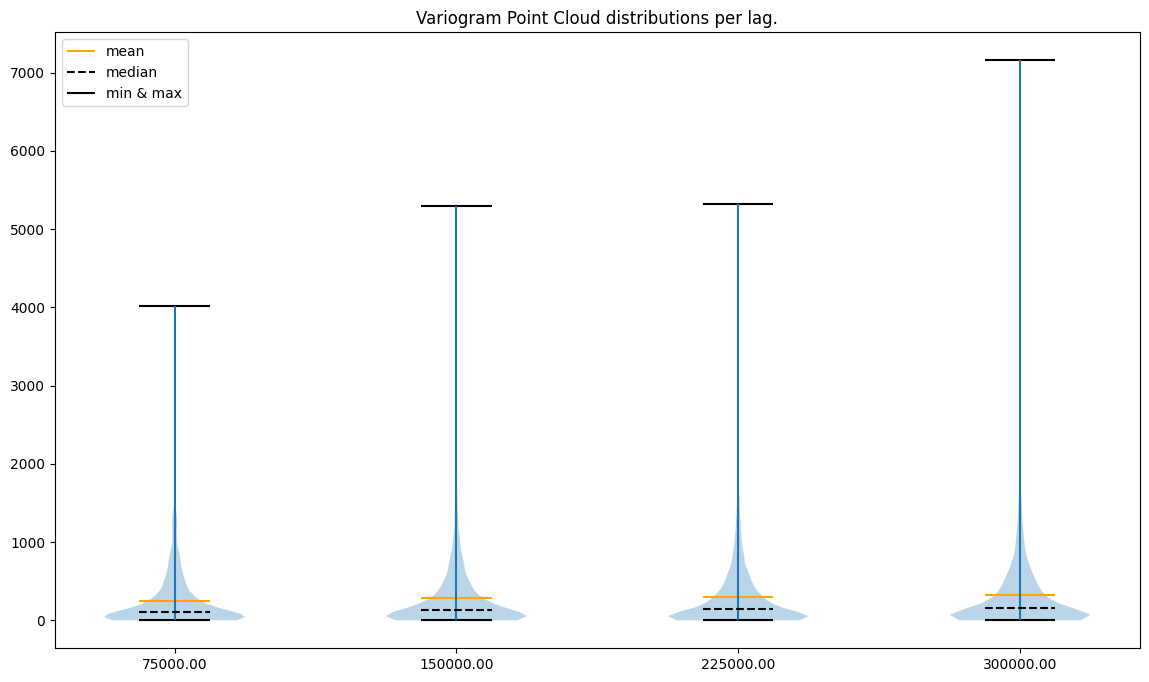


###########

Lags per area: 8



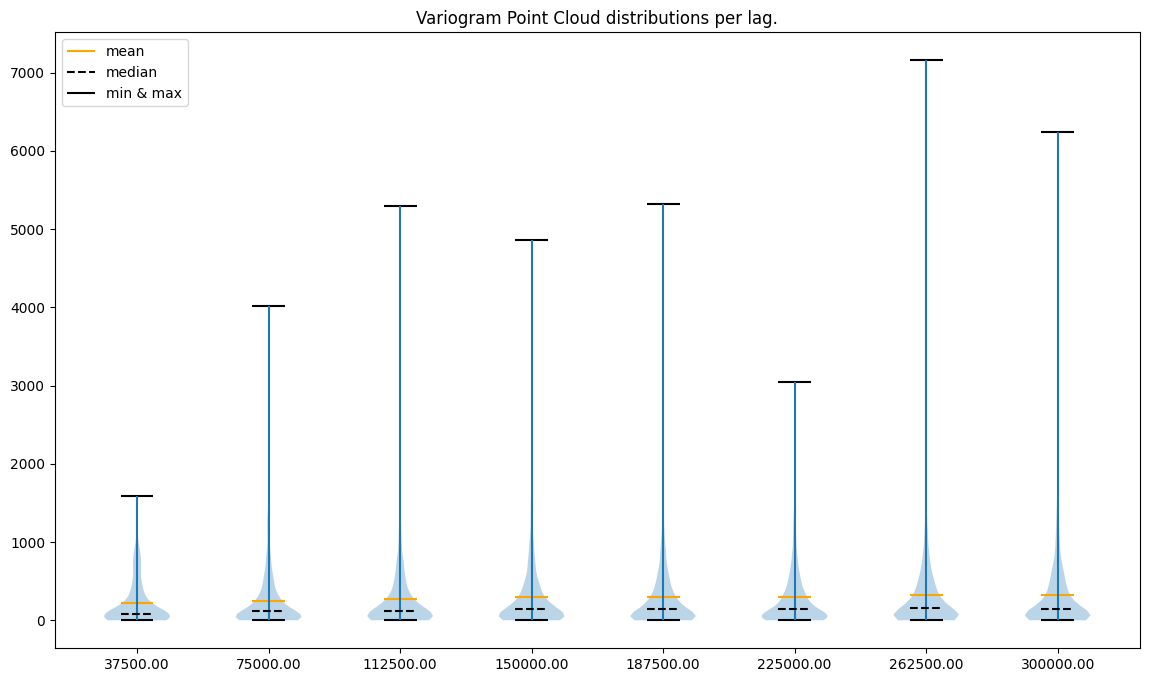


###########

Lags per area: 16



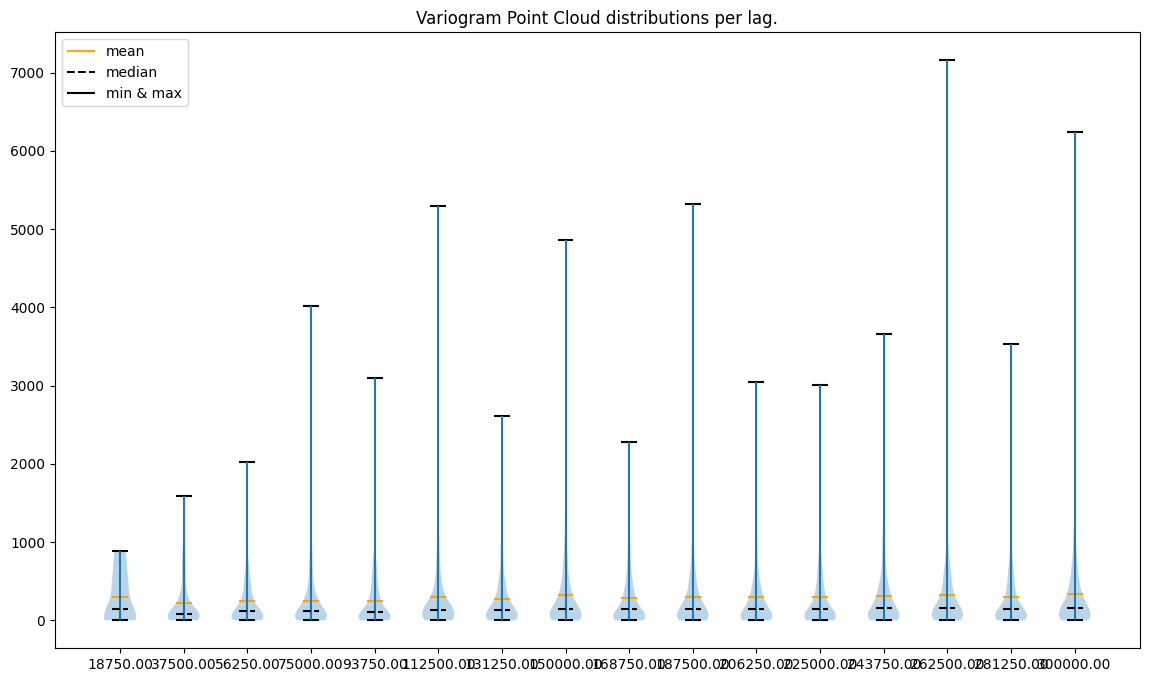


###########



In [6]:
for vc in variogram_clouds:
    print(f'Lags per area: {len(vc.lags)}')
    print('')
    vc.plot('violin')
    print('\n###########\n')

What do plots tell us?

- point to point errors per lag are skewed toward positive values (the mean is always greater than the median)
- less lags == less variability
- variability in the last case (16 lags) seems to be too high
- variability in the first case (4 lags) seems to be too small
- there are extreme semivariance values, and the largest extremities are present for the most distant lags

What can we do?

- remove outliers (extremely high semivariances) in each lag
- use a small number of neighbors and a range close to 200,000 to avoid unnecessary computations

In [7]:
# Now remove outliers from each lag

_ = [
    vc.remove_outliers(
        method='iqr',
        iqr_lower_limit=3,
        iqr_upper_limit=1.5,
        inplace=True
    ) for vc in variogram_clouds
]


Lags per area: 4



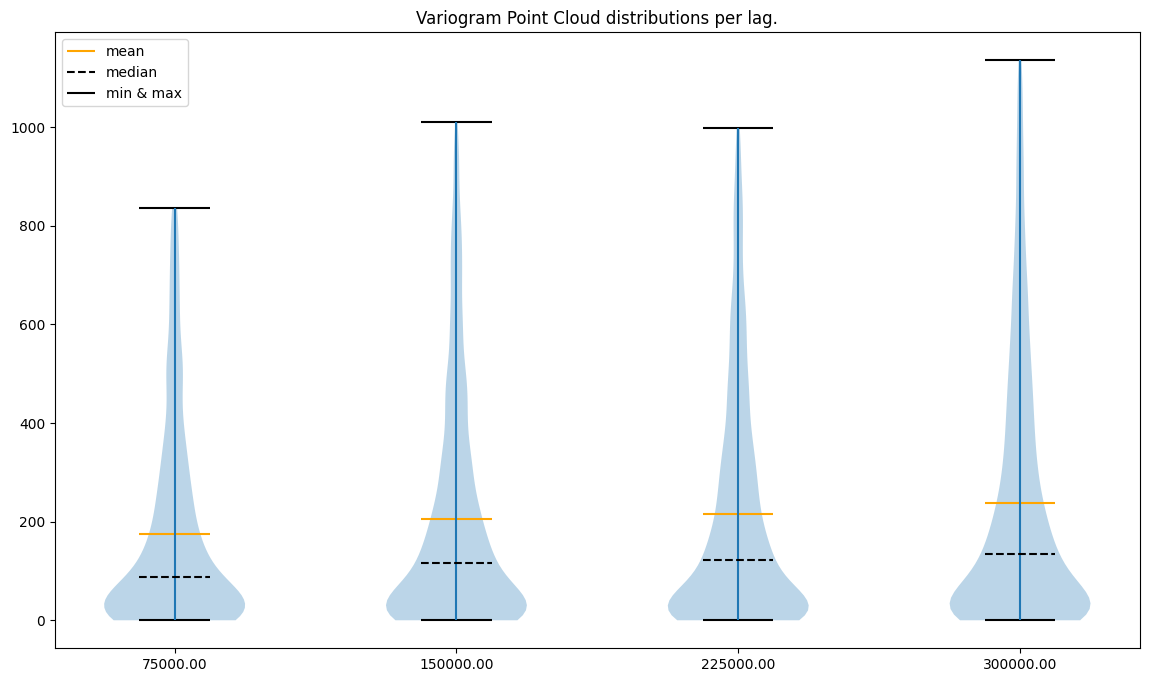


###########

Lags per area: 8



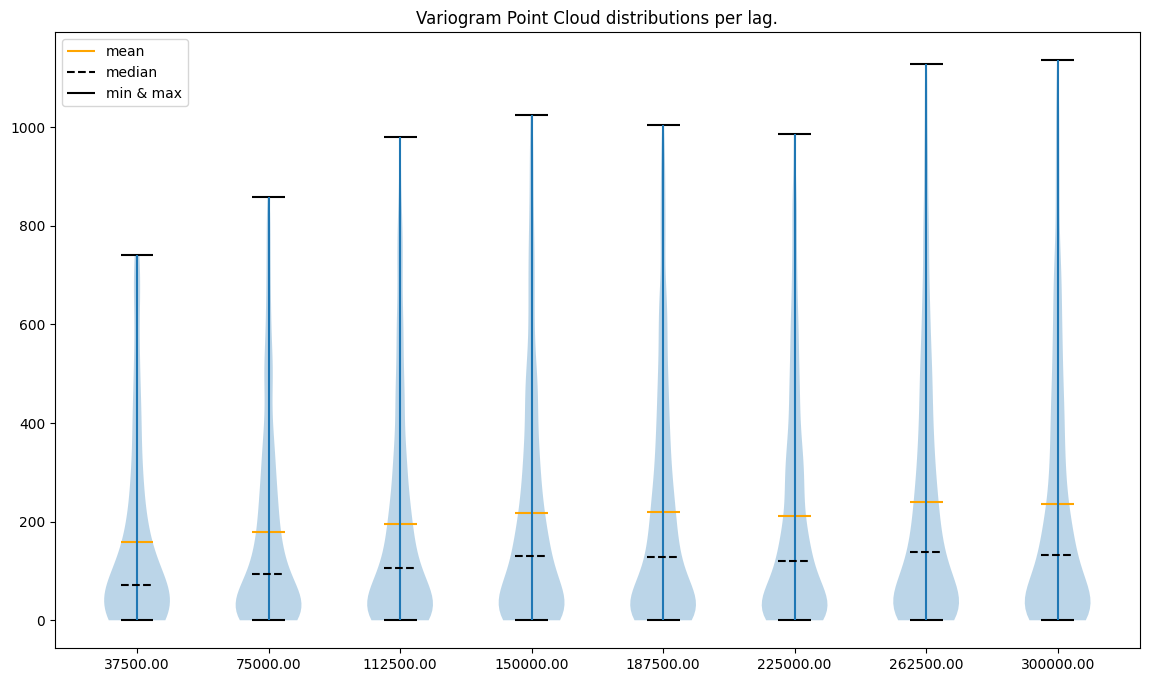


###########

Lags per area: 16



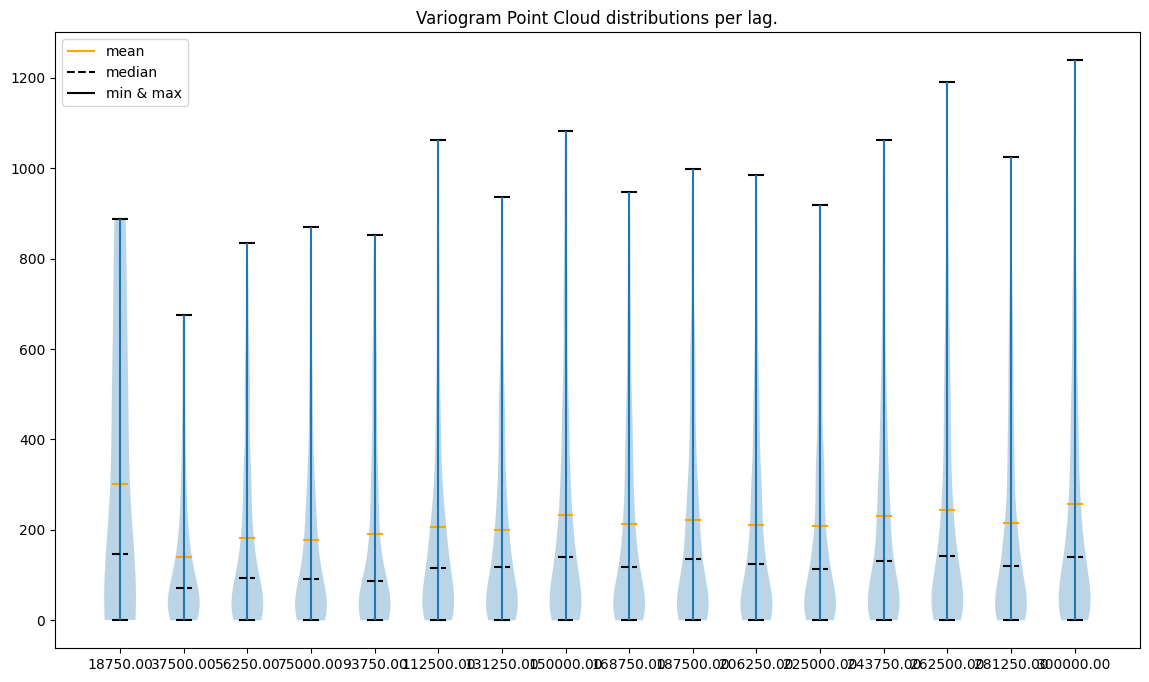


###########



In [8]:
# And show data without outliers

for vc in variogram_clouds:
    print(f'Lags per area: {len(vc.lags)}')
    print('')
    vc.plot('violin')
    print('\n###########\n')

If we compare the y axis before and after removing outliers, we may see that values are now smaller and densely populated. The variability for 16 lags, especially at the low ranges, is too high. Model build on top of this variogram might behave poorly.

## 3. Fit semivariogram model

Semivariogram may be fitted manually or automatically. In this case, we fit it automatically - we test multiple models. We didn't force any model to see how different results we would get.

In [9]:
theoretical_semivariograms = []

for idx, vc in enumerate(variogram_clouds):

    print(f'Semivariance calculated for {len(vc.lags)} lags.')

    # Calculate experimental model
    exp_model = vc.experimental_semivariances()

    # Assign experimental model and data to TheoreticalSemivariogram
    theo_semi = TheoreticalVariogram()
    theo_semi.autofit(experimental_variogram=exp_model)
    theoretical_semivariograms.append(theo_semi)
    print('')
    print('Model parameters:')
    print('Model type:', theo_semi.name)
    print('Nugget:', theo_semi.nugget)
    print('Sill:', theo_semi.sill)
    print('Range:', theo_semi.rang)
    print('Model error:', theo_semi.rmse)
    print('')
    print('')

Semivariance calculated for 4 lags.

Model parameters:
Model type: spherical
Nugget: 36.532706465067776
Sill: 114.18779541265431
Range: 130648.4129328959
Model error: 6.30055407864868


Semivariance calculated for 8 lags.

Model parameters:
Model type: spherical
Nugget: 56.31636235955056
Sill: 91.36955242757186
Range: 130648.4129328959
Model error: 9.444656398462776


Semivariance calculated for 16 lags.

Model parameters:
Model type: spherical
Nugget: 75.54535714285717
Sill: 78.4234809204555
Range: 165487.98971500146
Model error: 17.503272408247557




Each case has a different model type, a different sill, and a different range! How do we choose the model parameters appropriately in this scenario? Error rises with the number of lags but is it a good indicator of the semivariogram fit? No, and we should be careful when choosing variograms with a few lags instead of variograms with multiple lags. We may miss some spatial patterns that will be averaged with a smaller number of lags. We will choose variogram with 8 lags, even if the error is not the best.

## 4. Prepare canvas

Our variogram model is ready to load the point file as the GeoDataFrame object, which stores the geometry column and data features as tables.

In [10]:
gdf_pts = gpd.read_file(CANVAS)
gdf_pts.crs == AREAL_INPUT.ds.crs

True

In [11]:
gdf_pts.set_index('id', inplace=True)
gdf_pts['x'] = gdf_pts.geometry.x
gdf_pts['y'] = gdf_pts.geometry.y
gdf_pts.head()

,geometry,x,y
id,,,
81.0,POINT (1277277.671 441124.507),1.277278e+06,441124.5068
82.0,POINT (1277277.671 431124.507),1.277278e+06,431124.5068
83.0,POINT (1277277.671 421124.507),1.277278e+06,421124.5068
84.0,POINT (1277277.671 411124.507),1.277278e+06,411124.5068
85.0,POINT (1277277.671 401124.507),1.277278e+06,401124.5068


## 5. Interpolate

We can model all values in a batch using function `interpolate_points()`.

Based on the learning from a semivariogram modeling step, we will set a number of neighboring areas to 8 and range to 200000. We will append interpolated values and errors to an existing data frame and plot them to compare results.

In [12]:
preds_cols = []
errs_cols = []

for semi_model in theoretical_semivariograms:
    kriged = interpolate_points(
        theoretical_model=semi_model,
        known_locations=areal_centroids,
        unknown_locations=gdf_pts[['x', 'y']].to_numpy(),
        neighbors_range=200000,
        no_neighbors=16,
        use_all_neighbors_in_range=True
    )

    # Interpolate missing values and uncertainty
    pred_col_name = 'p ' + semi_model.name[:3] + ' ' + str(len(semi_model.lags))
    uncertainty_col_name = 'e ' + semi_model.name[:3] + ' ' + str(len(semi_model.lags))
    gdf_pts[pred_col_name] = kriged[:, 0]
    gdf_pts[uncertainty_col_name] = kriged[:, 1]
    preds_cols.append(pred_col_name)
    errs_cols.append(uncertainty_col_name)

100%|██████████| 5419/5419 [00:02<00:00, 2032.34it/s]


In [13]:
gdf_pts.head()

,geometry,x,y,p sph 4,e sph 4,p sph 8,e sph 8,p sph 16,e sph 16
id,,,,,,,,,
81.0,POINT (1277277.671 441124.507),1.277278e+06,441124.5068,131.303271,102.344082,131.303271,108.976595,133.188693,112.406723
82.0,POINT (1277277.671 431124.507),1.277278e+06,431124.5068,129.941316,100.671723,129.941316,107.638425,130.825540,111.300443
83.0,POINT (1277277.671 421124.507),1.277278e+06,421124.5068,129.054839,99.691185,129.054839,106.853829,129.958924,110.550631
84.0,POINT (1277277.671 411124.507),1.277278e+06,411124.5068,128.399447,99.077242,128.399447,106.362571,129.278133,110.092456
85.0,POINT (1277277.671 401124.507),1.277278e+06,401124.5068,128.291411,98.673959,128.291411,106.039877,129.212348,109.651128


Now we can save our `GeoDataFrame` as a geopackage or proceed with the analysis.

In [14]:
# Save interpolation results

# gdf_pts.to_file('interpolation_results_areal_to_point.gpkg')

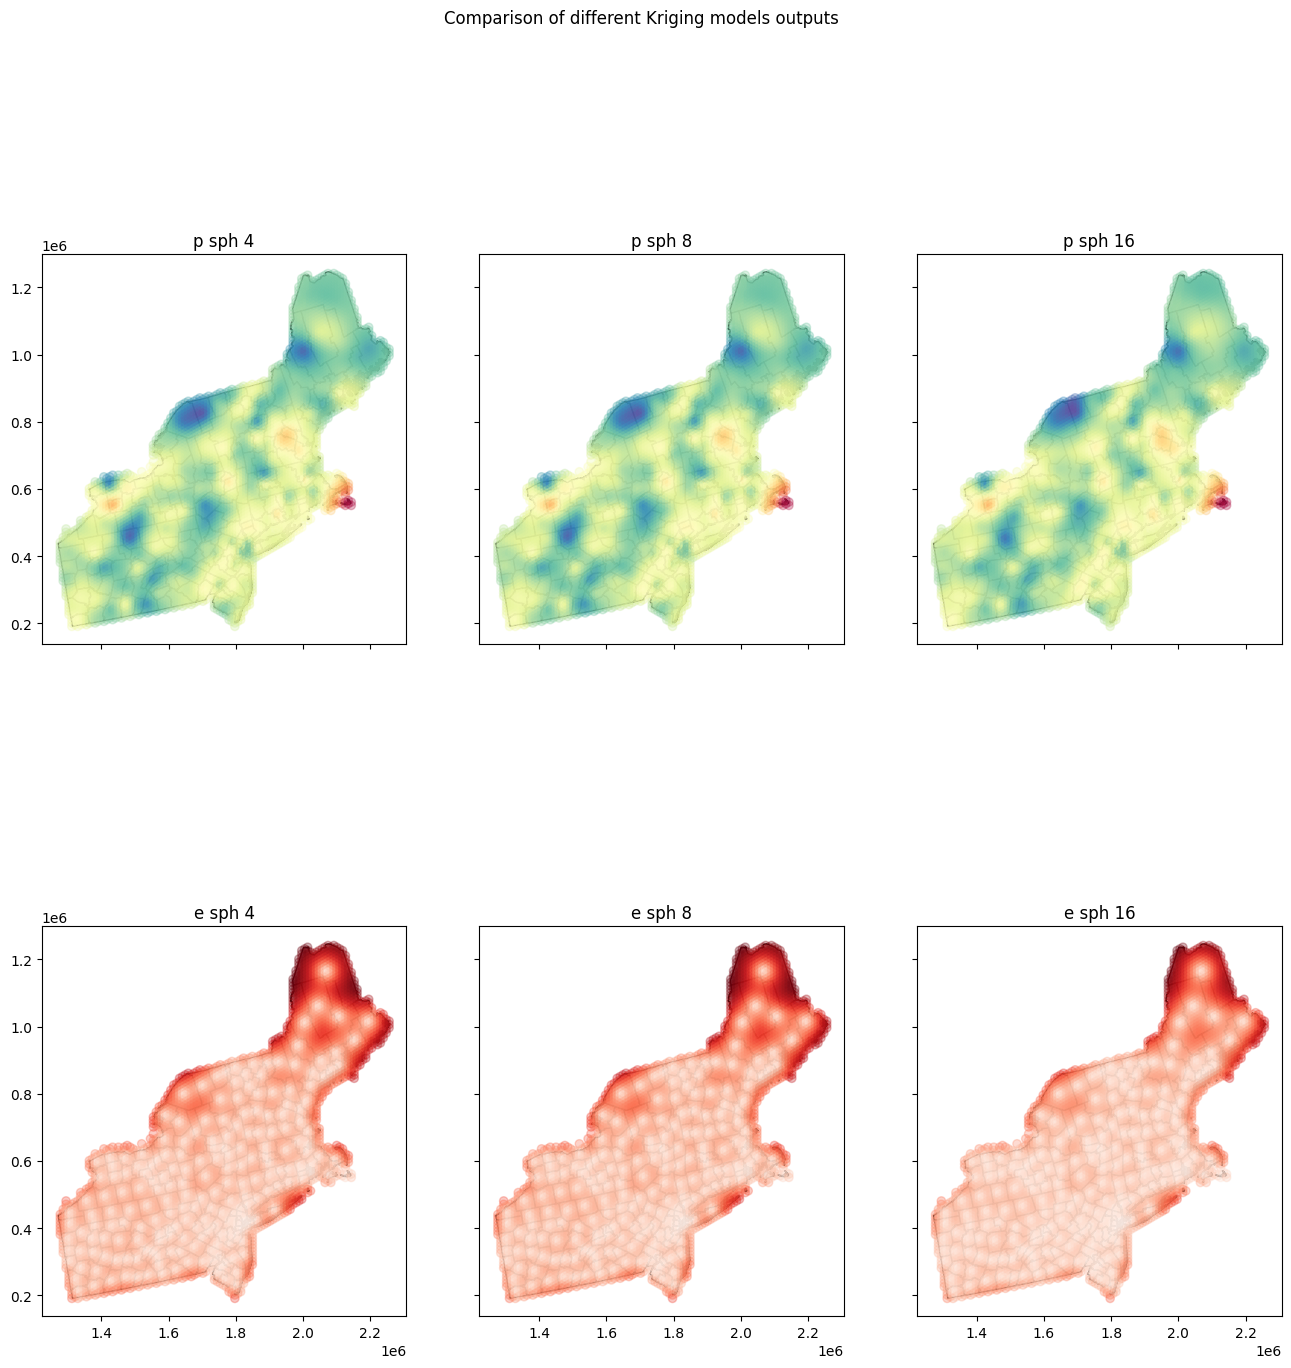

In [15]:
# Now compare results to choropleth maps
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 16), sharex='all', sharey='all')

base1 = AREAL_INPUT.ds.plot(ax=axes[0, 0], legend=True, edgecolor='black', color='white')
base2 = AREAL_INPUT.ds.plot(ax=axes[0, 1], legend=True, edgecolor='black', color='white')
base3 = AREAL_INPUT.ds.plot(ax=axes[0, 2], legend=True, edgecolor='black', color='white')
base4 = AREAL_INPUT.ds.plot(ax=axes[1, 0], legend=True, edgecolor='black', color='white')
base5 = AREAL_INPUT.ds.plot(ax=axes[1, 1], legend=True, edgecolor='black', color='white')
base6 = AREAL_INPUT.ds.plot(ax=axes[1, 2], legend=True, edgecolor='black', color='white')

gdf_pts.plot(ax=base1, column=preds_cols[0], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base2, column=preds_cols[1], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base3, column=preds_cols[2], cmap='Spectral_r', alpha=0.3)
gdf_pts.plot(ax=base4, column=errs_cols[0], cmap='Reds', alpha=0.3)
gdf_pts.plot(ax=base5, column=errs_cols[1], cmap='Reds', alpha=0.3)
gdf_pts.plot(ax=base6, column=errs_cols[2], cmap='Reds', alpha=0.3)

axes[0, 0].set_title(preds_cols[0])
axes[0, 1].set_title(preds_cols[1])
axes[0, 2].set_title(preds_cols[2])
axes[1, 0].set_title(errs_cols[0])
axes[1, 1].set_title(errs_cols[1])
axes[1, 2].set_title(errs_cols[2])

plt.suptitle('Comparison of different Kriging models outputs')
plt.show()

Are absolute errors between maps large or not? Let's check it in the last step:

In [16]:
for pcol1 in preds_cols:
    print('Column:', pcol1)
    for pcol2 in preds_cols:
        if pcol1 == pcol2:
            pass
        else:
            mad = gdf_pts[pcol1] - gdf_pts[pcol2]
            mad = np.abs(np.mean(mad))
            print(f'Mean Absolute Difference with {pcol2} is {mad:.9f}')
    print('')

Column: p sph 4
Mean Absolute Difference with p sph 8 is 0.000000000
Mean Absolute Difference with p sph 16 is 0.006794571

Column: p sph 8
Mean Absolute Difference with p sph 4 is 0.000000000
Mean Absolute Difference with p sph 16 is 0.006794571

Column: p sph 16
Mean Absolute Difference with p sph 4 is 0.006794571
Mean Absolute Difference with p sph 8 is 0.006794571



Model with 4 lags and model with 8 lags give almost the same results because range of both models is very close.

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-18 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |